<a href="https://colab.research.google.com/github/hrbae/LG_AI_training/blob/main/M2_System%20Optimization%20by%20ML/LG_Day2_Reinforcement%20Learning_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### LG 실습교육 (Reinforcement Learning & Python)    

**강화학습이란?**      

- 학습주체(Agent)가 행동과 경험을 반복하면서 최적의 답을 찾아나가는 학습 방법      
- 최적의 답을 찾아간다는 것은 Agent가 보상을 최대로 받을 수 있는 Action을 발견한다는 것을 의미함     

**강화학습의 활용**     

- 로보틱스, 게임, 스케쥴링 등 기존의 최적화 방법론으로는 해결하기 힘들었던 분야에 적용이 가능   

**강화학습의 구성요소**     

강화학습은 Agent가 Environment와 상호적으로 작용하며 학습을 진행.       
- Agent : 강화학습의 학습 주체로써, 주어진 환경(Environment)에서 행동(Action)을 반복을 함     
- Environment : 강화학습이 학습을 하는 공간을 포함, 강화학습에 필요한 모든 구성요소를 복합적으로 의미함     
- Policy : Agent로 하여금 보상(Reward) 기댓값을 최대화시키는 전략을 의미함       

**강화학습 구성요소**     
- 행동, Action($a_{t}$) : Agent가 학습 중에 선택할 수 있는 행동      
- 상태, State($s_{t}$) : Agent가 학습 중에 처한 상황을 의미함     
- 보상, Reward($r_{t}$) : Agent가 행동을 할 때마다 Environment는 해당 행동에 대하여 보상, 벌칙을 부여함       
- 감가율 discount factor($\gamma$) : 미래의 보상에 대해 감가율을 적용하는 Parameter         
- 학습율 learning rate($\alpha$) : 학습률의 의미로, policy를 update할 때마다 어느정도로 update할지를 결정    

#### 1. 작업자 배정 문제 - RL 활용    

- 목적: 총 비용 최소화
- 제약조건 1: 각 작업자를 최소 1개, 최대 3개 작업에 할당     
- 제약조건 2: 각 작업은 최소 1명의 작업자에게만 할당이 되어야 함   
- 제약조건 3: 작업자는 2개의 팀으로 분할되며, 각 팀은 최소 4개 이상 최대 7개 이하까지 작업할당이 가능

| Worker | Team   | Task 0 | Task 1 | Task 2 | Task 3 | Task 4 | Task 5 | Task 6 | Task 7 | Task 8 | Task 9 |
| ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ |
| 0      | Team 1 | 90     | 80     | 75     | 100    | 100    | 140    | 120    | 35     | 210    | 130    |
| 1      | Team 1 | 65     | 35     | 55     | 165    | 120    | 55     | 40     | 45     | 180    | 220    |
| 2      | Team 1 | 225    | 45     | 90     | 55     | 140    | 100    | 60     | 15     | 140    | 100    |
| 3      | Team 2 | 35     | 20     | 95     | 315    | 50     | 80     | 80     | 35     | 100    | 60     |
| 4      | Team 2 | 10     | 150    | 90     | 120    | 40     | 200    | 90     | 95     | 300    | 50     |
| 5      | Team 2 | 80     | 40     | 100    | 30     | 70     | 150    | 30     | 15     | 400    | 90     |

##### 1.1 강화학습 기본환경 구성

<img src=https://i.imgur.com/wAhomDq.png width="800" height ="500">

**보상정책**     
- 제약조건 1, 제약조건 3을 불만족할 경우 penalty 부여     
- 작업자 cost가 클수록 penalty 부여    
- 제약조건 2의 경우 Agent가 한명의 작업자만 선택하게 하였기 때문에 따로 설정할 필요 없음    

##### 1.2 강화학습 코드 구현 1    
- 기본설정 및 행동전략 등에 대해서는 동일   
- state를 index로 표현하기 위해 문자형(string)으로 변환하여 진행   

In [1]:
import numpy as np
import random
from collections import defaultdict
import copy
from types import MethodType

##### 1.3 강화학습 함수 정의     
- 비용 설정   
- $\epsilon$ 설정    
- $\gamma$ 설정    
- $\alpha$ 설정     
- $a_{t}$ 설정    
- 제약사항 정의    
- Q Table 정의

In [2]:
team1 = [0, 1, 2]
team2 = [3, 4, 5]
team_min = 4
team_max = 7
w_minimum = 1
w_maximum = 3

constraints = []
constraints.append(team1)
constraints.append(team2)
constraints.append(team_min)
constraints.append(team_max)
constraints.append(w_minimum)
constraints.append(w_maximum)

costs = [
    [90, 80, 75, 100, 100, 140, 120, 35, 210, 130],
    [65, 35, 55, 165, 120, 55, 40, 45, 180, 220],
    [225, 45, 90, 55, 140, 100, 60, 15, 140, 100],
    [35, 20, 95, 315, 50, 80, 80, 35, 100, 60],
    [10, 150, 90, 120, 40, 200, 90, 95, 300, 50],
    [80, 40, 100, 30, 70, 150, 30, 15, 400, 90]
]

num_workers = len(costs)
num_tasks = 3 

In [3]:
class taskAllocation:
    
    def __init__(self, epsilon, discount_factor, learning_rate, constraints):
        
        self.epsilon = epsilon
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        
        self.Action_Index = [0, 1, 2, 3, 4, 5]
        
        ########################## 빈칸 ##########################
        self.Action = "Action 정의"
        ##########################################################
        
        self.team1 , self.team2 , self.team_min , self.team_max , self.w_minimum , self.w_maximum  = constraints
        self.QTable = defaultdict(lambda : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
        
epsilon = 0.2
discount_factor = 0.9
learning_rate = 0.2

Allocation = taskAllocation(epsilon, discount_factor, learning_rate, constraints)

##### 1.4 Q를 최대로 하는 행동선택 정의         
- **def** arg_max_Moving, **def** Get_Moving 생성    
- 0~1사이의 난수 생성     
    - 생성된 난수가 $\epsilon$보다 작을 경우 임의 $a_{t}$ 선택 (탐험)   
    - 생성된 난수가 $\epsilon$보다 클 경우 Q를 최대로 하는 $a_{t}$ 선택 (탐욕)    

In [4]:
def arg_max_Moving(self,state_Moving):
    
    max_index_list = []
    max_value = state_Moving[0]
    
    for index, value in enumerate(state_Moving):
        
        if value > max_value:
            
            max_index_list.clear()
            max_value = value
            max_index_list.append(index)
            
        elif value == max_value:
            
            max_index_list.append(index)
            
    return random.choice(max_index_list)
    
Allocation.arg_max_Moving = MethodType(arg_max_Moving, Allocation)

In [5]:
def Get_Action(self, state):
    if np.random.rand() < self.epsilon:    
        ########################## 빈칸 ##########################
        Action = "탐험에 해당하는 action 선택"
        ##########################################################
        
    else:
        state_str = [str(x) for x in state]
        state_str2 = '.'.join(state_str)
        state_Moving = self.QTable[state_str2]
        ########################## 빈칸 ##########################
        Action = "탐욕에 해당하는 action 선택"
        ##########################################################
        
    return Action

Allocation.Get_Action = MethodType(Get_Action, Allocation)

##### 1.5 Agent의 행동에 따른 상태 변화 함수 정의      
- **def** Get_State 정의    
- Agent의 이동방향에 따라서 다음 상태($s_{t+1}$) 생성       
- 제약사항을 지키지 못 할 경우 penalty 부여  
<tab> - Constraint 1: 각 작업자 최소 1개, 최대 4개 작업에 할당 <br>
<tab> - Constraint 2: 작업자는 2개의 팀으로 분할되며, 각 팀은 최소 4개이상 최대 7개 이하까지 작업할당이 가능
- 정상 범위로 진행 했다면 cost 계산하여 반영

In [6]:
def Get_State(self, x, costs, steps, Action, team1, team2):
    
    ## Constraint 1: 각 작업자 최소 1개, 최대 4개 작업에 할당
    ########################## 빈칸 ##########################
    "제약 사항 1 구현"
    ##########################################################
    
    
    ##  Constraint 2: 작업자는 2개의 팀으로 분할되며, 각 팀은 최소 2개이상 최대 7개 이하까지 작업할당이 가능
    if sum(x[team1,:].sum(axis=1)) < self.team_min:
        penalty3_1 = -10
    else:
        penalty3_1 = 0
    if sum(x[team1,:].sum(axis=1)) > self.team_max:
        penalty3_2 = -10
    else:
        penalty3_2 = 0
    if sum(x[team2,:].sum(axis=1)) < self.team_min:
        penalty3_3 = -10
    else:
        penalty3_3 = 0
    if sum(x[team2,:].sum(axis=1)) > self.team_max:
        penalty3_4 = -10
    else:
        penalty3_4 = 0
        
    ########################## 빈칸 ##########################
    cost = "현재 action의 cost"
    ##########################################################
    reward = penalty1_1 + penalty1_2 + penalty3_1 + penalty3_2 + penalty3_3 + penalty3_4 + cost
    
    return reward

Allocation.Get_State = MethodType(Get_State, Allocation)

##### 1.6 Agent의 행동에 Q Table 학습    
- $Q[s,a]$ 업데이트 진행    
$$
Q(s_{t},a_{t})=Q(s_{t},a_{t})+ \alpha [r_{t+1}+ \gamma max_{a}Q(s_{t+1},a)-Q(s_{t},a_{t})]
$$       

In [7]:
def Q_learning(self, state, next_state, reward):
    
    Action = next_state[-1]
    state_str = [str(x) for x in state]
    state_str2 = '.'.join(state_str)
    ########################## 빈칸 ##########################
    Q1 = "현재 state q-value"
    ##########################################################
    
    nextstate_str = [str(x) for x in next_state]
    nextstate_str2 = '.'.join(nextstate_str)
    ########################## 빈칸 ##########################
    Q2 = "미래 state q-value"
    ##########################################################
    
    ########################## 빈칸 ##########################
    "q-value 업데이트"
    ##########################################################
    
Allocation.Q_learning = MethodType(Q_learning, Allocation)

##### 1.7 강화학습 진행 1   
- $\epsilon$=0.2    
- $\gamma$=0.9    
- $\alpha$=0.2      
- 먼저, 최대 task를 3으로 설정한 후 진행     
- Episode 수는 500으로 진행   

In [8]:
E = []
rewardList = []
costList = []

num_episode = 500
for e in range(num_episode):
    
    state = []
    x = np.zeros((num_workers, num_tasks))
        
    total_reward = 0 
    steps = 0
    total_cost = 0
    
    while True:
    
        Action = Allocation.Get_Action(state)
        x[Action, steps] += 1
        
        reward = Allocation.Get_State(x, costs, steps, Action, team1, team2)
        next_state = copy.deepcopy(state)
        next_state.append(Action)
        Allocation.Q_learning(state, next_state, reward)
        
        total_reward += reward
        state = copy.deepcopy(next_state)
        total_cost += costs[Action][steps]
        steps += 1

        
        if steps == num_tasks:
            costList.append(total_cost)
            E.append(e)
            rewardList.append(total_reward)
            
            break

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

**학습결과 확인**

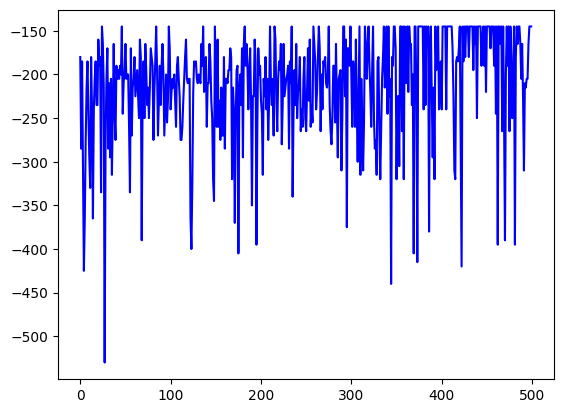

In [ ]:
import pylab
pylab.plot(E, rewardList,'b')

**최소 cost 출력**

In [ ]:
min(costList)

85

**QTable 확인**

In [ ]:
print(Allocation.QTable[""])

[-131.39761372425167, -132.45042688625483, -237.63731539967998, -128.80221501083955, -126.74999973079072, -130.48385014714057]


In [ ]:
print(Allocation.QTable["1.1"])

[-34.2, -27.0, -39.6, -23.0, -39.6, -24.0]


##### 1.8 강화학습 진행 2 
- $\epsilon$=0.2    
- $\gamma$=0.9    
- $\alpha$=0.2      
- 최대 task를 9로 설정한 후 진행    
- Episode 수를 10,000으로 증가   

In [ ]:
# Allocation = taskAllocation(epsilon, discount_factor, learning_rate, constraints)
Allocation.QTable = defaultdict(lambda : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
Allocation.epsilon = 0.2
Allocation.discount_factor = 0.9
Allocation.learning_rate = 0.2

num_workers = len(costs)
num_tasks = len(costs[0])
num_episode = 50000

E = []
rewardList = []
costList = []

for e in range(num_episode):
    
    state = []
    x = np.zeros((num_workers, num_tasks))
        
    total_reward = 0 
    steps = 0
    total_cost = 0
    
    while True:
    
        Action = Allocation.Get_Action(state)
        x[Action, steps] += 1
        
        reward = Allocation.Get_State(x, costs, steps, Action, team1, team2)
        next_state = copy.deepcopy(state)
        next_state.append(Action)
        Allocation.Q_learning(state, next_state, reward)
        
        total_reward += reward
        state = copy.deepcopy(next_state)
        total_cost += costs[Action][steps]
        
        steps += 1

        
        if steps == num_tasks:
            costList.append(total_cost)
            E.append(e)
            rewardList.append(total_reward)
            
            break

**학습결과 확인**

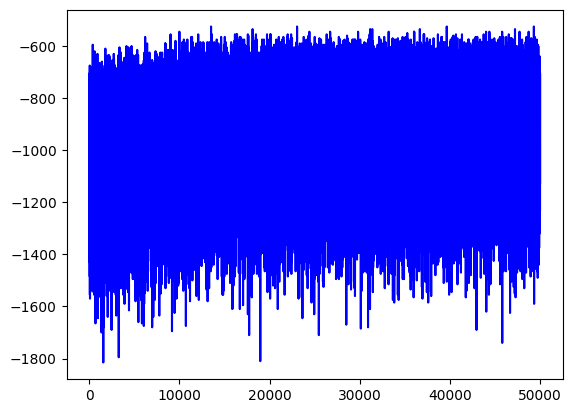

In [ ]:
pylab.plot(E, rewardList,'b')       

최소 코스트

In [ ]:
min(costList)

405

- 강화학습이 더 좋은 조건을 찾아낸 것을 확인할 수 있음   

#### 2. 강화학습 예시 문제 - 경로 생성   

**강화학습을 활용하여 선박이 목적지까지 가는 경로를 찾는 문제를 풀고자 함**
- Agent : 선박     
- Action : 방향선택     
- Environment : 해역     
- Reward : 목적지를 찾을 경우 부여 (실패할 경우에는 Penalty를 부여)        

**강화학습 진행 단계**       

1. Agent의 초기 State($s_{1}$) 결정    
2. Agent Action($a_{1}$) 실행   
3. Environment로부터 Action($a_{1}$)에 따른 Reward($r_{1}$) 수령    
    - 목적지로부터 가까워졌을 경우에는 +1, 멀어졌을 경우에는 -1점     
4. Agent는 다음 State($s_{2}$)로 이동

- 위 2~4번의 step을 목적지를 찾을 때까지 반복    
- 만약 학습과정에서 강제 종료(Break)조건을 주었을 경우, 상황에 따라 학습을 강제 종료하고 새로운 학습 시작    
- Agent가 학습을 반복할때마다 Policy가 Update되면서 보상을 최대로 하는 정답을 찾을 수가 있음

<img src=https://i.imgur.com/yHF8Gvr.png width="600" height = "400">

**Grid Map 설명**
- Agent가 선택할 수 있는 Action은 총 4개(상,하,좌,우)      
- 검은 블록은 장애물(통과 불가능) 
- 파랑 블록이 목적지점     

##### 2.1 강화학습 기본환경 구성

In [ ]:
### Environment Generate    

### 0 : 통과 가능
### 1 : 통과 불가능 지역      
### 2 : 목적지

import numpy as np

Grid = np.matrix([
    [0,0,0,0,0],
    [0,1,0,0,0],
    [0,1,0,1,0],
    [0,0,1,1,0],
    [1,0,0,1,2]
])


Grid

matrix([[0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 1, 0],
        [0, 0, 1, 1, 0],
        [1, 0, 0, 1, 2]])

In [ ]:
class Path_Finding:
    
    def __init__(self,Grid, epsilon,discount_factor,learning_rate):

        self.Grid = Grid
        self.epsilon = epsilon
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate

        self.Action_Index = [0,1,2,3] # 상하좌우
        self.Action = [[-1,0],[1,0],[0,-1],[0,1]]
        self.Nrow = self.Grid.shape[0] - 1
        self.Ncol = self.Grid.shape[1] - 1

        self.QTable = defaultdict(lambda : [0.0, 0.0, 0.0, 0.0])
        
    def arg_max_Moving(self,state_Moving):
        
        max_index_list = []
        max_value = state_Moving[0]
        
        for index, value in enumerate(state_Moving):
            
            if value > max_value:
                
                max_index_list.clear()
                max_value = value
                max_index_list.append(index)
                
            elif value == max_value:
                
                max_index_list.append(index)
                
        return random.choice(max_index_list)
    
    def Get_Moving(self,state):
        
        if np.random.rand() < self.epsilon:
            ################################### 빈칸 ###########################################
            Moving = np.random.choice(self.Action_Index)
            ####################################################################################
            
        else:
            ################################### 빈칸 ###########################################
            state_Moving = self.QTable[state[0],state[1]]
            Moving = self.arg_max_Moving(state_Moving = state_Moving)
            ####################################################################################
            
        return Moving
    
    def Get_State(self, Moving, state,State_History):
        
        Next_State = copy.deepcopy(state)
        
        Next_State[0] += self.Action[Moving][0]
        Next_State[1] += self.Action[Moving][1]    
        
        Penalty = "No"
        
        if Next_State[0] < 0 or Next_State[1] < 0 or Next_State[0] > self.Nrow or Next_State[1] > self.Ncol \
            or [Next_State[0],Next_State[1]] in State_History or self.Grid[state[0],state[1]] == 1:
                
            Next_State[0] = state[0]
            Next_State[1] = state[1]
            
            Penalty = "Yes"
            
        return(Next_State, Penalty)
    
    def Get_Reward(self, Next_state, Penalty ,Terminal_State):
        
        Reward = 0 
        
        ################################### 빈칸 ###########################################
        if Penalty == "No":
            Reward += 1
        else:
            Reward -= 1
            
        if Next_state == Terminal_State:
            Reward += 1
        ####################################################################################
            
        return Reward       
    
    def Moving_Learning(self, state, Next_State, Reward, Moving):
        
        Q1 = self.QTable[state[0],state[1]][Moving]
        Q2 = Reward + self.discount_factor * max(self.QTable[Next_State[0],Next_State[1]])
        
        self.QTable[state[0],state[1]][Moving] += self.learning_rate*(Q2-Q1)

##### 2.2 강화학습 진행     
- $\epsilon$ = 0.1     
- $\gamma$ = 0.9    
- $\alpha$ = 0.01

In [ ]:
PF = Path_Finding(Grid = Grid, epsilon = 0.1, learning_rate = 0.01, discount_factor = 0.9)

# Episode 수  
e = 300

# 보상결과 저장 리스트
Reward_List = [] 
E = [] 

# 성공/실패 횟수
Success = 0
Break = 0

# 강화학습 진행
for episode in range(e):
    
    # 학습결과값 초기화 진행
    Reward_Total = 0 
    Total_Step = 0
    steps = 0 
    
    state = [0,0]
    Terminal_State = [4,4]
    
    State_History = [] 
    State_History.append(state)
    
    # Episode가 종료될 때까지 반복
    while True:
        
        # Action 선택
        Moving = PF.Get_Moving(state = state)
        # State 업데이트 
        Get_State = PF.Get_State(Moving = Moving,
                                 state = state,
                                State_History = State_History)
        
        Next_State = Get_State[0]
        Penalty = Get_State[1]
        
        # 보상 계산
        Reward = PF.Get_Reward(Next_state = Next_State,
                               Penalty = Penalty,
                               Terminal_State = Terminal_State)
        
        Reward -= 1
        
        # Q Table 학습
        PF.Moving_Learning(state = state,
                           Next_State = Next_State,
                           Reward = Reward,
                           Moving = Moving)
        
        Reward_Total += Reward
        
        steps += 1
        # Agent의 state가 변하지 않았을 경우 (이동할 수 없는 위치로 이동하였을 때)
        if state != Next_State:
            
            State_History.append(Next_State)
            
            Total_Step += 1
            state = copy.deepcopy(Next_State)
            
        # Agent가 목적지에 도착할 경우
        if state == Terminal_State:
            
            Success += 1
            Reward_List.append(Reward_Total)
            E.append(episode)
            
            break
            
        # Agent의 trail이 최대허용치를 초과할 경우
        if steps == 30:
            
            Break += 1
            Reward_List.append(Reward_Total)
            E.append(episode)
            
            break

**학습결과 확인** 

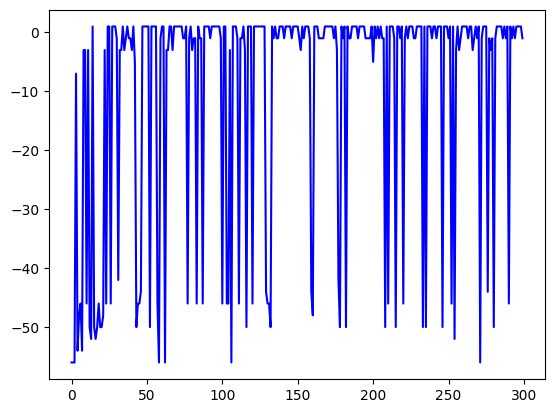

In [ ]:
import pylab
pylab.plot(E, Reward_List,'b')

**Q Table 확인**

In [ ]:
print(PF.QTable[0,0])

[-0.20931589754977686, -3.977027136862539e-15, -0.20928932562365427, 0.0021233981175219907]


In [ ]:
print(PF.QTable[1,0])

[-0.02, -1.576469697289276e-12, -0.02, -0.002324409082698118]


##### 2.3 강화학습 진행     
- $\epsilon$ = 0.3     
- $\gamma$ = 0.9    
- $\alpha$ = 0.01

In [ ]:
PF = Path_Finding(Grid = Grid, epsilon = 0.3, learning_rate = 0.01, discount_factor = 0.9)

# Episode 수  
e = 300

# 보상결과 저장 리스트
Reward_List = [] 
E = [] 

# 성공/실패 횟수
Suceess = 0
Break = 0

# 강화학습 진행
for episode in range(e):
    
    # 학습결과값 초기화 진행
    Reward_Total = 0 
    Total_Step = 0
    steps = 0 
    
    state = [0,0]
    Terminal_State = [4,4]
    
    State_History = [] 
    State_History.append(state)
    
    # Episode가 종료될 때까지 반복
    while True:
        
        # Action 선택
        Moving = PF.Get_Moving(state = state)
        # State 업데이트 
        Get_State = PF.Get_State(Moving = Moving,
                                 state = state,
                                State_History = State_History)
        
        Next_State = Get_State[0]
        Penalty = Get_State[1]
        
        # 보상 계산
        Reward = PF.Get_Reward(Next_state = Next_State,
                               Penalty = Penalty,
                               Terminal_State = Terminal_State)
        
        Reward -= 1
        
        # Q Table 학습
        PF.Moving_Learning(state = state,
                           Next_State = Next_State,
                           Reward = Reward,
                           Moving = Moving)
        
        Reward_Total += Reward
        
        steps += 1
        
        if state != Next_State:
            
            State_History.append(Next_State)
            
            Total_Step += 1
            state = copy.deepcopy(Next_State)
            
        if state == Terminal_State:
            
            Suceess += 1
            Reward_List.append(Reward_Total)
            E.append(episode)
            
            break
            
        if steps == 30:
            
            Break += 1
            Reward_List.append(Reward_Total)
            E.append(episode)
            
            break

**학습결과 확인**

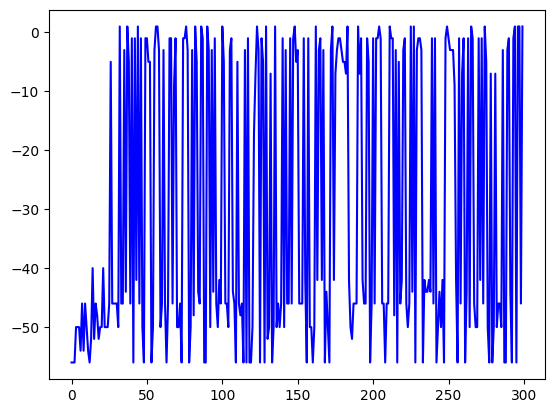

In [ ]:
import pylab
pylab.plot(E, Reward_List,'b')

**Q Table 확인**     
$$
Q[state]={r_{1},r_{2}, r_{3}, r_{4}}
$$

In [ ]:
print(PF.QTable[0,0])

[-0.5056516418837549, -2.7146608859733003e-10, -0.5500336689920441, 0.0002242145917118976]


In [ ]:
print(PF.QTable[1,0])

[-0.1545106111460066, -8.155610917081685e-09, -0.039800000047891, -0.03587634244752954]
